In [1]:
import pandas as pd
import numpy as np
from eodhd import APIClient
import sys
sys.path.insert(0, "/Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src")
from Features import fundamental_features_new, fundamental_features, technical_features
import talib
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import sklearn
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import optuna
from optuna import Trial
import shap


## Data Extraction

In [2]:
zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')
zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['per_end_date'] = zacks_fc['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fc['filing_date'] = pd.to_datetime(zacks_fc['filing_date'])
zacks_fc['filing_date'] = zacks_fc['filing_date'].dt.tz_localize('US/Eastern')
zacks_fc = zacks_fc.sort_values('per_end_date').set_index('per_end_date')

zacks_fr = pd.read_csv("../data/fundamental_data/ZACKS_FR.csv", delimiter=',')
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_fr['per_end_date'] = zacks_fr['per_end_date'].dt.tz_localize('US/Eastern')
zacks_fr = zacks_fr.sort_values('per_end_date').set_index('per_end_date')

data = {
    "zacks_fc": zacks_fc,
    "zacks_fr": zacks_fr
}

C:\Users\manis\AppData\Local\Temp\ipykernel_20160\3539703636.py:1: DtypeWarning: Columns (4,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  zacks_fc = pd.read_csv("../data/fundamental_data/ZACKS_FC.csv", delimiter=',')


MemoryError: Unable to allocate 1.01 GiB for an array with shape (197, 686842) and data type float64

In [6]:
obj = fundamental_features_new.BuildFeatures(data, 'AAPL')
obj.process_financial_statements()
obj.extend_monthly()
tech = technical_features.BuildFeatures('AAPL')
tech.build_technical_features()
tech.technical_features.index = tech.technical_features.index.tz_convert('US/Eastern')
obj.features = pd.merge_asof(obj.fundamental_features, tech.technical_features, left_index=True, right_index=True, direction='backward')

obj.stock.sort_index(inplace=True)
obj.features = pd.merge_asof(obj.features, obj.stock[['Close']],left_index=True, right_index=True, direction='backward')

obj.features.rename(columns={'Close': 'Close_Price'}, inplace=True)

c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\fundamental_features_new.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.fundamental_features.loc[:, "eps"].fillna(self.data['zacks_fc'].loc[:, "basic_net_eps"], inplace=True)
c:\Users\manis\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `i

Error: Moving_Average_Convergence/Divergence_Fix_12/26
Error: Stochastic
Error: Stochastic_Fast
Error: Stochastic_RSI


c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:497: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Variance"] = talib.VAR(self.stock["Close"], timeperiod=5, nbdev=1)
c:\Users/manis/Desktop/UChicago Docs/Winter Quarter/Project Lab 36001/Factor-Research/src\Features\technical_features.py:500: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.technical_features["Weighted_Close_Price"] = talib.WCLPRICE(self.stock["High"], self.stock["L

In [8]:
obj.features.head()

,total revenue,ebitda,eps,Dividend Payout Ratio,total_current_assets,,m_ticker,ticker,comp_name,comp_name_2,...,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price,Close_Price
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-04-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.95036554,6395,2.11828899,6404,58.72283697,2.03872915,2.04707794,0.06319641,2.11828899,2.11828876
2006-05-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.79869437,6426,2.05087852,6413,60.46856892,1.87294298,1.89749801,0.09329067,1.79869437,1.79869449
2006-06-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.68584323,6446,1.79297614,6442,54.01379359,1.74043271,1.69808207,0.07433114,1.72346032,1.72345984
2006-07-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.52484286,6457,2.04516125,6468,52.27348030,1.94148095,1.86498210,0.09148449,2.04516125,2.04516029
2006-08-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.92418456,6478,2.06893444,6487,59.63377094,2.03045118,2.07871220,0.04935402,2.04185009,2.04184985


In [9]:
start_date = '2006-01-01'
end_date = '2025-01-01'

In [10]:
print(tech.technical_features.shape)
print(obj.fundamental_features.shape)

(11138, 125)
(223, 45)


In [11]:
obj.features['Dividend Payout Ratio'].isna().sum()

223

All rows in divident payout ratio are NaN values - need to check

In [14]:
final_df = obj.features.copy()
final_df = final_df.sort_index()
final_df

,total revenue,ebitda,eps,Dividend Payout Ratio,total_current_assets,,m_ticker,ticker,comp_name,comp_name_2,...,Lowest_value_over_period,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price,Close_Price
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-04-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.95036554,6395,2.11828899,6404,58.72283697,2.03872915,2.04707794,0.06319641,2.11828899,2.11828876
2006-05-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.79869437,6426,2.05087852,6413,60.46856892,1.87294298,1.89749801,0.09329067,1.79869437,1.79869449
2006-06-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.68584323,6446,1.79297614,6442,54.01379359,1.74043271,1.69808207,0.07433114,1.72346032,1.72345984
2006-07-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.52484286,6457,2.04516125,6468,52.27348030,1.94148095,1.86498210,0.09148449,2.04516125,2.04516029
2006-08-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,NaN,11286.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,1.92418456,6478,2.06893444,6487,59.63377094,2.03045118,2.07871220,0.04935402,2.04185009,2.04184985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 20:00:00-04:00,90753.00000000,30736.00000000,1.53000000,NaN,128416.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,192.47311401,10963,215.94422913,10968,5993.53625488,211.17402465,215.54830280,5.75067630,209.91447449,209.91447449
2024-07-31 20:00:00-04:00,85777.00000000,28202.00000000,1.40000000,NaN,125435.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,216.76148987,10994,234.03343201,10987,6605.60908508,217.57200902,224.45998680,5.00317423,221.33610535,221.33610535
2024-08-31 20:00:00-04:00,85777.00000000,28202.00000000,1.40000000,NaN,125435.00000000,NaN,AAPL,AAPL,Apple,Apple Inc.,...,220.78408813,11007,229.28536987,11019,6619.78601074,227.92413420,226.44932624,2.91358566,228.49710083,228.49710083


## Applying Regressor

In [15]:
nan_counts = final_df.isnull().sum()
print(nan_counts[nan_counts > 1])
len(nan_counts[nan_counts > 1])

Dividend Payout Ratio         223
                              223
per_code                      223
non_perform_asset_tot_loan    223
loan_loss_reserve             223
lterm_debt_cap                 86
tot_debt_tot_equity            86
ebitda_margin                 223
loss_ratio                    223
exp_ratio                     223
comb_ratio                    223
dtype: int64


11

In [16]:
drop_cols = final_df.columns[nan_counts > 1]
final_df = final_df.drop(drop_cols, axis=1)
final_df.shape

(223, 160)

In [17]:
matching = [col for col in final_df.columns if 'return' in col.lower() or 'price' in col.lower()]
matching

['Absolute_Price_Oscillator',
 'Average_Price',
 'Typical_Price',
 'Weighted_Close_Price',
 'Percentage_Price_Oscillator',
 'Median_Price',
 'Midpoint_Price_over_period',
 'Close_Price',
 'Close_Price']

In [63]:
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

final_df['next_return'] = final_df['Close_Price'].shift(-1) / final_df['Close_Price'] - 1
final_df['next_return_median'] = final_df['Median_Price'].shift(-1) / final_df['Median_Price'] - 1
print(final_df.shape)


(223, 161)


In [64]:
final_df.head()

,total revenue,ebitda,eps,total_current_assets,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,...,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Summation,Triple_Exponential_Moving_Average,Triple_Exponential_Moving_Average_Oscillator,True_Range,Close_Price,next_return,next_return_median
filing_date,,,,,,,,,,,,,,,,,,,,,
2006-04-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,11286.00000000,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,...,6395,2.11828899,6404,58.72283697,2.03872915,2.04707794,0.06319641,2.11828899,-0.15087395,-0.14249152
2006-05-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,11286.00000000,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,...,6426,2.05087852,6413,60.46856892,1.87294298,1.89749801,0.09329067,1.79869437,-0.04182704,-0.05170966
2006-06-30 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,11286.00000000,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,...,6446,1.79297614,6442,54.01379359,1.74043271,1.69808207,0.07433114,1.72346032,0.18665990,0.18083146
2006-07-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,11286.00000000,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,...,6457,2.04516125,6468,52.27348030,1.94148095,1.86498210,0.09148449,2.04516125,-0.00161902,0.00037049
2006-08-31 20:00:00-04:00,4359.00000000,579.00000000,0.01680000,11286.00000000,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,...,6478,2.06893444,6487,59.63377094,2.03045118,2.07871220,0.04935402,2.04185009,0.13456179,0.14256057


In [65]:
train_df = final_df['2006-04-30':'2019-01-01'].copy()
valid_df = final_df['2019-01-01': '2022-01-01'].copy()
test_df = final_df['2022-01-01':].copy()

In [68]:
x_train = train_df.drop(['next_return', 'next_return_median'], axis=1)
y_train = train_df['next_return']
y_train_median = train_df['next_return_median']

x_valid = valid_df.drop(['next_return', 'next_return_median'], axis=1)
y_valid = valid_df['next_return']
y_valid_median = valid_df['next_return_median']

x_test = test_df.drop(['next_return', 'next_return_median'], axis=1)
y_test = test_df['next_return']
y_test_median = test_df['next_return_median']

In [69]:
# 1. Identify numeric and non-numeric columns in x_train
numeric_cols = x_train.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
non_numeric_cols = x_train.select_dtypes(exclude=['int64', 'float64', 'int32', 'float32']).columns

# 2. Initialize the scaler and scale the numeric columns
scaler = StandardScaler()
x_train_numeric_scaled = scaler.fit_transform(x_train[numeric_cols])
x_valid_numeric_scaled = scaler.transform(x_valid[numeric_cols])
x_test_numeric_scaled = scaler.transform(x_test[numeric_cols])

# 3. Convert the scaled numeric arrays back to DataFrames
x_train_numeric_scaled_df = pd.DataFrame(x_train_numeric_scaled, columns=numeric_cols, index=x_train.index)
x_valid_numeric_scaled_df = pd.DataFrame(x_valid_numeric_scaled, columns=numeric_cols, index=x_valid.index)
x_test_numeric_scaled_df = pd.DataFrame(x_test_numeric_scaled, columns=numeric_cols, index=x_test.index)

# 4. Combine scaled numeric columns with the unscaled non-numeric columns
#x_train_final = pd.concat([x_train_numeric_scaled_df, x_train[non_numeric_cols]], axis=1)
#x_valid_final = pd.concat([x_valid_numeric_scaled_df, x_valid[non_numeric_cols]], axis=1)
#x_test_final = pd.concat([x_test_numeric_scaled_df, x_test[non_numeric_cols]], axis=1)

# Optionally, reorder columns to match the original order in x_train
#x_train_final = x_train_final[x_train.columns]
#x_valid_final = x_valid_final[x_valid.columns]
#x_test_final = x_test_final[x_test.columns]

# Now x_train_final, x_valid_final, and x_test_final have the numeric features scaled and the string features intact.
rf = RandomForestRegressor(random_state=1)
rf.fit(x_train_numeric_scaled_df, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred = rf.predict(x_valid_numeric_scaled_df)
mse_valid = mean_squared_error(y_valid, y_valid_pred)
print("Validation MSE:", mse_valid)

Validation MSE: 0.012810063541664292


In [70]:
# using median price
rf_med = RandomForestRegressor(random_state=2)
rf_med.fit(x_train_numeric_scaled_df, y_train_median)

# Optionally, predict and evaluate on the validation set
y_valid_pred_med = rf_med.predict(x_valid_numeric_scaled_df)
mse_valid_med = mean_squared_error(y_valid_median, y_valid_pred_med)
print("Validation MSE:", mse_valid_med)

Validation MSE: 0.01212997466170996


In [71]:
# Using the model's built-in score method
r2_builtin = rf.score(x_valid_numeric_scaled_df, y_valid)
print("R^2 score (built-in):", r2_builtin)

# Alternatively, predict and then compute R² with r2_score:
y_valid_pred = rf.predict(x_valid_numeric_scaled_df)
r2 = r2_score(y_valid, y_valid_pred)
print("R^2 score:", r2)

R^2 score (built-in): -0.817479708307439
R^2 score: -0.817479708307439


In [72]:
# Using median price
r2_builtin_med = rf_med.score(x_valid_numeric_scaled_df, y_valid_median)
print("R^2 score (built-in):", r2_builtin_med)

# Alternatively, predict and then compute R² with r2_score:
y_valid_pred_med = rf_med.predict(x_valid_numeric_scaled_df)
r2_med = r2_score(y_valid_median, y_valid_pred_med)
print("R^2 score:", r2_med)

R^2 score (built-in): -0.6900157854900335
R^2 score: -0.6900157854900335


In [73]:
x_train[non_numeric_cols].head()

,m_ticker,ticker,comp_name,comp_name_2,exchange,currency_code,per_type
filing_date,,,,,,,
2006-04-30 20:00:00-04:00,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,Q
2006-05-31 20:00:00-04:00,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,Q
2006-06-30 20:00:00-04:00,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,Q
2006-07-31 20:00:00-04:00,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,Q
2006-08-31 20:00:00-04:00,AAPL,AAPL,Apple,Apple Inc.,NASDAQ,USD,Q


## Optuna Implementation

In [104]:
def objective(trial: Trial, train=None, labels=None, val=None, val_labels=None):
    # Suggest hyperparameters
    rf_n_estimators = trial.suggest_int('n_estimators', 10, 100, step=5)
    rf_max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    rf_max_depth = trial.suggest_int('max_depth', 2, 10)
    
    rf_reg = RandomForestRegressor(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_leaf=rf_min_samples_leaf,
        max_features=rf_max_features,
        random_state=1
    )
    
    rf_reg.fit(train, labels)
    preds = rf_reg.predict(val)
    
    # Compute R-squared score
    r2 = r2_score(val_labels, preds)
    return r2

In [105]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, train=x_train_numeric_scaled_df, labels=y_train, val=x_valid_numeric_scaled_df, val_labels=y_valid), n_trials=400)

[I 2025-02-20 22:14:07,693] A new study created in memory with name: no-name-88b64e15-2037-4d59-a6e8-4f804b6e1a2c


[I 2025-02-20 22:14:07,817] Trial 0 finished with value: -0.48196574044389306 and parameters: {'n_estimators': 55, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'max_depth': 4}. Best is trial 0 with value: -0.48196574044389306.
[I 2025-02-20 22:14:07,858] Trial 1 finished with value: -0.4505244674330109 and parameters: {'n_estimators': 40, 'max_features': 'log2', 'min_samples_leaf': 6, 'max_depth': 7}. Best is trial 1 with value: -0.4505244674330109.
[I 2025-02-20 22:14:07,912] Trial 2 finished with value: -1.271009785007375 and parameters: {'n_estimators': 45, 'max_features': 'log2', 'min_samples_leaf': 1, 'max_depth': 7}. Best is trial 1 with value: -0.4505244674330109.
[I 2025-02-20 22:14:08,028] Trial 3 finished with value: -0.7170488355574212 and parameters: {'n_estimators': 70, 'max_features': 'log2', 'min_samples_leaf': 3, 'max_depth': 10}. Best is trial 1 with value: -0.4505244674330109.
[I 2025-02-20 22:14:08,073] Trial 4 finished with value: -0.1905589452795453 and parameter

In [106]:
study.best_params

{'n_estimators': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'max_depth': 2}

In [111]:
rf = RandomForestRegressor(**study.best_params)

In [112]:
rf.fit(x_train_numeric_scaled_df, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred_op = rf.predict(x_valid_numeric_scaled_df)
mse_valid_op = mean_squared_error(y_valid, y_valid_pred_op)
print("Validation MSE:", mse_valid_op)

Validation MSE: 0.008797123152797029


In [113]:
# predict and then compute R2 with r2_score:
y_valid_pred_op = rf.predict(x_valid_numeric_scaled_df)
r2 = r2_score(y_valid, y_valid_pred_op)
print("R^2 score:", r2)

ss_res = np.sum((y_valid - y_valid_pred_op) ** 2)
ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
#r2_manual = 1 - (ss_res / ss_tot)

#print("Manual R² score:", r2_manual)
print("SS total:", ss_tot)
print("SS residual:", ss_res)

R^2 score: -0.24812751862532245
SS total: 0.2537372414074324
SS residual: 0.31669643350069304


## Feature Importance

                             Feature  Importance
109               Standard_Deviation  0.05849306
27                            SMA_50  0.05660944
34                Average_True_Range  0.04656433
63                  Long_Legged_Doji  0.03932003
86   Pearson_Correlation_Coefficient  0.03757207
..                               ...         ...
55          Modified_Hikkake_Pattern  0.00000000
54                   Hikkake_Pattern  0.00000000
53                  High_Wave_Candle  0.00000000
52              Harami_Cross_Pattern  0.00000000
151                      Close_Price  0.00000000

[152 rows x 2 columns]


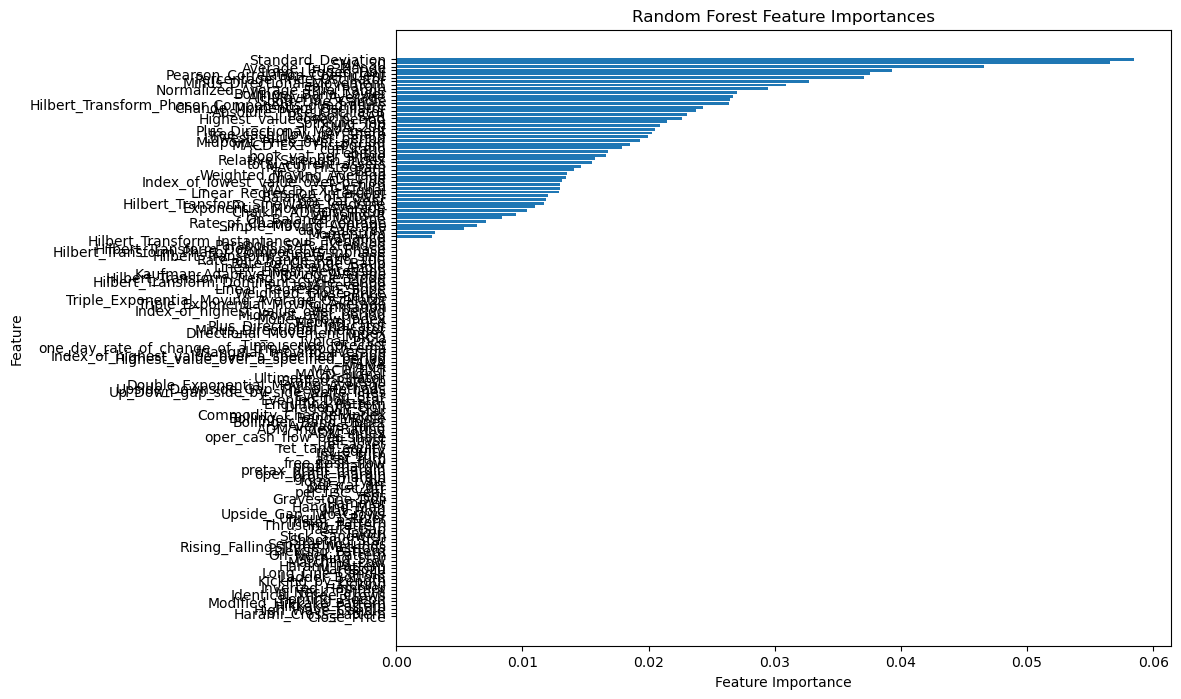

In [114]:
# Get feature importances from the model
importances = rf.feature_importances_

# Create a DataFrame for easier viewing and sorting
feature_importance_df = pd.DataFrame({
    'Feature': x_train_numeric_scaled_df.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

In [115]:
features = feature_importance_df[feature_importance_df['Importance'] > 0.01]
features.shape

(42, 2)

In [1]:
features

NameError: name 'features' is not defined

In [116]:
x_train_red = x_train_numeric_scaled_df[features['Feature']]
x_valid_red = x_valid_numeric_scaled_df[features['Feature']]
x_test_red = x_test_numeric_scaled_df[features['Feature']]
x_train_red.shape

(153, 42)

In [117]:
rf = RandomForestRegressor(random_state=1)
rf.fit(x_train_red, y_train)

# Optionally, predict and evaluate on the validation set
y_valid_pred_red = rf.predict(x_valid_red)
mse_valid_red = mean_squared_error(y_valid, y_valid_pred_red)
print("Validation MSE:", mse_valid_red)

Validation MSE: 0.013985634584899586


In [119]:
# predict and then compute R2 with r2_score:
y_valid_pred_red = rf.predict(x_valid_red)
r2 = r2_score(y_valid, y_valid_pred_red)
print("R^2 score:", r2)

ss_res = np.sum((y_valid - y_valid_pred_red) ** 2)
ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
#r2_manual = 1 - (ss_res / ss_tot)

#print("Manual R² score:", r2_manual)
print("SS total:", ss_tot)
print("SS residual:", ss_res)

R^2 score: -0.9842686168717729
SS total: 0.2537372414074324
SS residual: 0.5034828450563851


## Using Median Price

In [85]:
def objective_med(trial: Trial, train=None, labels=None, val=None, val_labels=None):
    # Suggest hyperparameters
    rf_n_estimators = trial.suggest_int('n_estimators', 10, 100, step=5)
    rf_max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    rf_max_depth = trial.suggest_int('max_depth', 2, 10)
    
    rf_reg = RandomForestRegressor(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_leaf=rf_min_samples_leaf,
        max_features=rf_max_features,
        random_state=2
    )
    
    rf_reg.fit(train, labels)
    preds = rf_reg.predict(val)
    
    # Compute R-squared score
    r2 = r2_score(val_labels, preds)
    return r2

In [94]:
study_med = optuna.create_study(direction="maximize")
study_med.optimize(lambda trial: objective_med(trial, train=x_train_numeric_scaled_df, labels=y_train_median, val=x_valid_numeric_scaled_df, val_labels=y_valid_median), n_trials=400)

[I 2025-02-20 21:19:40,075] A new study created in memory with name: no-name-2026392a-1ce0-4102-87b7-f2f8406e42d9
[I 2025-02-20 21:19:40,199] Trial 0 finished with value: -0.6780250702208725 and parameters: {'n_estimators': 95, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'max_depth': 8}. Best is trial 0 with value: -0.6780250702208725.
[I 2025-02-20 21:19:40,269] Trial 1 finished with value: -0.4878674344135401 and parameters: {'n_estimators': 60, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'max_depth': 4}. Best is trial 1 with value: -0.4878674344135401.
[I 2025-02-20 21:19:40,319] Trial 2 finished with value: -0.2090723647225441 and parameters: {'n_estimators': 45, 'max_features': 'log2', 'min_samples_leaf': 4, 'max_depth': 2}. Best is trial 2 with value: -0.2090723647225441.
[I 2025-02-20 21:19:40,365] Trial 3 finished with value: -0.3088033889462136 and parameters: {'n_estimators': 40, 'max_features': 'log2', 'min_samples_leaf': 5, 'max_depth': 10}. Best is trial 2 with value

In [95]:
study_med.best_params

{'n_estimators': 15,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'max_depth': 8}

In [96]:
rf_med = RandomForestRegressor(**study_med.best_params)

In [97]:
rf_med.fit(x_train_numeric_scaled_df, y_train_median)

# Optionally, predict and evaluate on the validation set
y_valid_pred_op_med = rf_med.predict(x_valid_numeric_scaled_df)
mse_valid_op_med = mean_squared_error(y_valid_median, y_valid_pred_op_med)
print("Validation MSE:", mse_valid_op_med)

Validation MSE: 0.009909312648525737


In [98]:
y_valid_pred_op_med = rf_med.predict(x_valid_numeric_scaled_df)
r2_med = r2_score(y_valid_median, y_valid_pred_op_med)
print("R^2 score:", r2_med)

ss_res_med = np.sum((y_valid_median - y_valid_pred_op_med) ** 2)
ss_tot_med = np.sum((y_valid_median - np.mean(y_valid_median)) ** 2)
r2_manual_med = 1 - (ss_res_med / ss_tot_med)

print("Manual R2 score:", r2_manual_med)
print("SS total:", ss_tot_med)
print("SS residual:", ss_res_med)

R^2 score: -0.3806207569607356
Manual R2 score: -0.3806207569607356
SS total: 0.25838757931775175
SS residual: 0.3567352553469265


               Feature  Importance
40    Balance_of_Power  0.04930188
115           MACD_EXT  0.03045313
150         True_Range  0.02973368
31           ADM_Index  0.02844853
119               FAMA  0.02825080
..                 ...         ...
61   Kicking_by_Length  0.00000000
116    MACD_EXT_Signal  0.00000000
60             Kicking  0.00000000
118               MAMA  0.00000000
76     Stalled_Pattern  0.00000000

[152 rows x 2 columns]


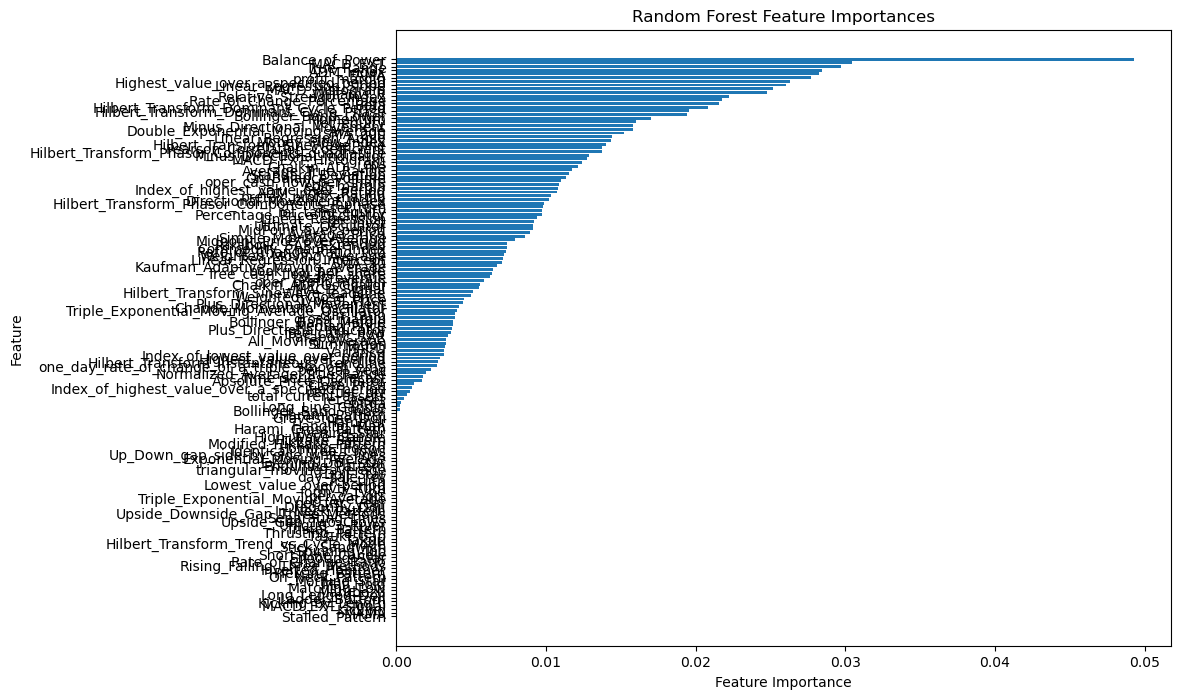

In [99]:
# Get feature importances from the model
importances_med = rf_med.feature_importances_

# Create a DataFrame for easier viewing and sorting
feature_importance_df_med = pd.DataFrame({
    'Feature': x_train_numeric_scaled_df.columns,
    'Importance': importances_med
}).sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df_med)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df_med['Feature'], feature_importance_df_med['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features on top
plt.show()

In [100]:
features_med = feature_importance_df_med[feature_importance_df_med['Importance'] > 0.01]
features_med.shape

(39, 2)

In [101]:
x_train_red_med = x_train_numeric_scaled_df[features_med['Feature']]
x_valid_red_med = x_valid_numeric_scaled_df[features_med['Feature']]
x_test_red_med = x_test_numeric_scaled_df[features_med['Feature']]
x_train_red_med.shape

(153, 39)

In [103]:
rf_med = RandomForestRegressor(random_state=2)
rf_med.fit(x_train_red_med, y_train_median)

# Optionally, predict and evaluate on the validation set
y_valid_pred_red_med = rf_med.predict(x_valid_red_med)
mse_valid_red_med = mean_squared_error(y_valid_median, y_valid_pred_red_med)
print("Validation MSE:", mse_valid_red_med)

# predict and then compute R2 with r2_score:
r2_med = r2_score(y_valid_median, y_valid_pred_red_med)
print("R^2 score:", r2_med)

ss_res_med = np.sum((y_valid_median - y_valid_pred_red_med) ** 2)
ss_tot_med = np.sum((y_valid_median - np.mean(y_valid_median)) ** 2)

print("SS total:", ss_tot)
print("SS residual:", ss_res)

Validation MSE: 0.014593509295457198
R^2 score: -1.0332491833533166
SS total: 0.2537372414074324
SS residual: 0.48054021186657886


## Shapley Values